In [5]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import ipython_genutils

In [6]:
class read_eplusql:
    def __init__(self,file,read="all",):
        
        self.myconn = sql.connect(file)
        if (read=="data") or (read=="all"):
            command = "SELECT ReportDataDictionaryIndex, KeyValue, Name, Units FROM ReportDataDictionary"
            variables = pd.read_sql_query(command,con=self.myconn)

            variables['variable_name'] = variables.KeyValue + ':' + variables.Name + ' (' + variables.Units + ')'
            self.variables = variables
            self.vars = variables.variable_name.unique()

            command = "SELECT tm.TimeIndex, tm.Year, tm.Month, tm.Day, tm.Hour, tm.Minute FROM Time AS tm"
            time = pd.read_sql_query(command,con=self.myconn)
            time = time[time.Year!=0]
            command = """SELECT ReportData.TimeIndex, ReportData.ReportDataDictionaryIndex, ReportData.Value
              FROM (ReportData INNER JOIN ReportDataDictionary ON ReportData.ReportDataDictionaryIndex = ReportDataDictionary.ReportDataDictionaryIndex) 
              INNER JOIN Time ON ReportData.TimeIndex = Time.TimeIndex"""
            data = pd.read_sql_query(command,con=self.myconn)
            data_variables = pd.merge(data,self.variables)
            data_variables_time = pd.merge(data_variables,time)
            df = data_variables_time.copy()
            df['date'] = pd.to_datetime(df[['Year','Month','Day']])
            df.loc[df.Hour==24,'date'] += pd.Timedelta('1D')
            df.loc[df.Hour==24,'Hour'] = 0
            df['date'] = pd.to_datetime(df[['Year','Month','Day','Hour','Minute']])
            df['variable_name'] = df.KeyValue + ':' + df.Name + ' (' + df.Units + ')'
            df  = df.pivot_table(index="date", columns="variable_name", values="Value")
    #         df  = df.pivot(index="date", columns="variable_name", values="Value")
            self.data = df
    
        
        if (read=="construction") or (read=="all"):
#             print("aca")
            command = """SELECT * FROM  Materials """
            m       = pd.read_sql_query(command,con=self.myconn)
            m = m.rename(columns={'Name': 'NameMaterial'})
            # 
            command = """SELECT * FROM  Constructions """
            c = pd.read_sql_query(command,con=self.myconn)
            c = c.rename(columns={'Name': 'NameConstruction'})
            # 
            command = """SELECT * FROM  ConstructionLayers """
            l = pd.read_sql_query(command,con=self.myconn)
            ml   = pd.merge(m,l)
            mlc = pd.merge(ml,c)
            self.mlc = mlc
            self.construction_systems = mlc.NameConstruction.unique()
            

    def get_data(self,names):
        result = [variable for name in names for variable in self.vars if name in variable]
        return self.data[result]
    def get_construction(self,names_cs,round=4):
#         all = []
        for name_cs in names_cs:
            properties = ['NameMaterial','Conductivity', 'Density','SpecHeat', 'Thickness', 
                          'TotalLayers', 'InsideAbsorpVis', 'OutsideAbsorpVis','InsideAbsorpSolar',
                          'OutsideAbsorpSolar', 'InsideAbsorpThermal',
                          'OutsideAbsorpThermal', 'OutsideRoughness']
            cs = self.mlc.loc[self.mlc.NameConstruction==name_cs].sort_values('ConstructionLayersIndex')[properties]
            thickness =  cs['Thickness'].sum().round(round)
            total_layers = cs.TotalLayers.unique()
            InsideAbsopVis = cs.InsideAbsorpVis.unique()
            OutsideAbsopVis = cs.OutsideAbsorpVis.unique()
            OutsideAbsorpSolar = cs.OutsideAbsorpSolar.unique()
            InsideAbsorpThermal = cs.InsideAbsorpThermal.unique()
            OutsideAbsorpThermal = cs.OutsideAbsorpThermal.unique()
            OutsideRoughness = cs.OutsideRoughness.unique()
#             dictio = {'Construction system':name_cs,
#                       'Total thickness':thickness,
#                       'Total layers':total_layers,
#                       'InsideAbsorpVis':InsideAbsopVis,
#                       "OutsideAbsorpVis":OutsideAbsopVis,
#                       "OutsideAbsorpSolar":OutsideAbsorpSolar,
#                       "InsideAbsorpThermal":InsideAbsorpThermal,
#                       "OutsideRoughness":OutsideRoughness
#                      }
            print('\n')
            print(f'Construction system:\033[1m{name_cs}\033[0m')
            print(f'Total thickness    :{thickness} m')
            print(f'Total layers:{total_layers}')
            print(f"InsideAbsorpVis:{InsideAbsopVis}")
            print(f"OutsideAbsorpVis:{OutsideAbsopVis}")
            print(f"OutsideAbsorpSolar:{OutsideAbsorpSolar}")
            print(f"InsideAbsorpThermal:{InsideAbsorpThermal}")
            print(f"OutsideRoughness:{OutsideRoughness}")
            properties = ['NameMaterial','Conductivity', 'Density','SpecHeat', 'Thickness']
            display(cs[properties].style.hide_index())
            print('\n\n\n')
#         return all


In [7]:
df = read_eplusql("../data/001_raw/eplusoutTo.sql",read='all') # by default reads everything
# df = read_eplusql("../data/eplusoutTo.sql",read='construction') # reads only construction systems
# df = read_eplusql("../data/eplusoutTo.sql",read='data') # reads only data


In [8]:
cs = df.construction_systems
cs

array(['M-05_AIRE_M-05', 'PS-01', 'PS-01 REVERSED', 'PS-02', 'PS-12',
       'PS-05', 'M-16_MC-04_M-16', 'MC-04', 'MC-04_M-16',
       'TRABE_CONCRETO', 'M-06', 'M-08', 'CIELOFALSO', 'MDF',
       'PUERTA METALICA', 'M-05', 'M-05 REVERSED', 'VENTANA_10MM',
       'VENTANA_6MM', 'APERTURA'], dtype=object)

In [9]:
df.get_construction(cs)



Construction system:M-05_AIRE_M-05
Total thickness    :0.6 m
Total layers:[7]
InsideAbsorpVis:[0.3]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[3]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
TABIQUE_HUECO_C1_L20_A30,0.700000,1715.480000,800.000000,0.025400
TABIQUE_HUECO_C2_L100,0.233000,526.100000,942.160000,0.089200
TABIQUE_HUECO_C3_L20_A30,0.700000,1715.480000,800.000000,0.025400
AIRE_L320,0.025510,1.184000,1007.000000,0.320000
TABIQUE_HUECO_C3_L20_A30,0.700000,1715.480000,800.000000,0.025400
TABIQUE_HUECO_C2_L100,0.233000,526.100000,942.160000,0.089200
TABIQUE_HUECO_C1_L20_A30,0.700000,1715.480000,800.000000,0.025400








Construction system:PS-01
Total thickness    :0.25 m
Total layers:[2]
InsideAbsorpVis:[0.7]
OutsideAbsorpVis:[0.7]
OutsideAbsorpSolar:[0.7]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[3]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
CONCRETO_FC150_L80_A70,1.300000,1800.000000,1000.000000,0.080000
CONCRETO_FC250_L170,2.000000,2400.000000,1000.000000,0.170000








Construction system:PS-01 REVERSED
Total thickness    :0.25 m
Total layers:[2]
InsideAbsorpVis:[0.7]
OutsideAbsorpVis:[0.7]
OutsideAbsorpSolar:[0.7]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[3]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
CONCRETO_FC250_L170,2.000000,2400.000000,1000.000000,0.170000
CONCRETO_FC150_L80_A70,1.300000,1800.000000,1000.000000,0.080000








Construction system:PS-02
Total thickness    :0.25 m
Total layers:[2]
InsideAbsorpVis:[0.7]
OutsideAbsorpVis:[0.7]
OutsideAbsorpSolar:[0.7]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[3]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
CONCRETO_FC150_MARMOL_L80_A70,1.300000,1800.000000,1000.000000,0.080000
CONCRETO_FC250_L170,2.000000,2400.000000,1000.000000,0.170000








Construction system:PS-12
Total thickness    :0.25 m
Total layers:[2]
InsideAbsorpVis:[0.7]
OutsideAbsorpVis:[0.7]
OutsideAbsorpSolar:[0.7]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[3]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
CONCRETO_FC150_MARMOL_L80_A70,1.300000,1800.000000,1000.000000,0.080000
CONCRETO_FC250_L170,2.000000,2400.000000,1000.000000,0.170000








Construction system:PS-05
Total thickness    :0.445 m
Total layers:[3]
InsideAbsorpVis:[0.7]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[1]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
IMPERMEABILIZANTE_L5_A30,0.160000,1121.290000,1460.000000,0.005000
VERMICULITA_L270,0.190000,700.000000,800.000000,0.270000
CONCRETO_FC250_L170,2.000000,2400.000000,1000.000000,0.170000








Construction system:M-16_MC-04_M-16
Total thickness    :0.22 m
Total layers:[3]
InsideAbsorpVis:[0.3]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[5]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
FACHALETA_L10_A30,0.700000,1970.000000,800.000000,0.010000
CONCRETO_FC250_L200_A70,2.000000,2400.000000,1000.000000,0.200000
FACHALETA_L10_A30,0.700000,1970.000000,800.000000,0.010000








Construction system:MC-04
Total thickness    :0.2 m
Total layers:[1]
InsideAbsorpVis:[0.7]
OutsideAbsorpVis:[0.7]
OutsideAbsorpSolar:[0.7]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[3]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
CONCRETO_FC250_L200_A70,2.000000,2400.000000,1000.000000,0.200000








Construction system:MC-04_M-16
Total thickness    :0.21 m
Total layers:[2]
InsideAbsorpVis:[0.3]
OutsideAbsorpVis:[0.7]
OutsideAbsorpSolar:[0.7]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[3]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
CONCRETO_FC250_L200_A70,2.000000,2400.000000,1000.000000,0.200000
FACHALETA_L10_A30,0.700000,1970.000000,800.000000,0.010000








Construction system:TRABE_CONCRETO
Total thickness    :0.3 m
Total layers:[1]
InsideAbsorpVis:[0.7]
OutsideAbsorpVis:[0.7]
OutsideAbsorpSolar:[0.7]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[5]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
CONCRETO_TRABE_L300_A70,2.000000,1800.000000,1000.000000,0.300000








Construction system:M-06
Total thickness    :0.09 m
Total layers:[3]
InsideAbsorpVis:[0.3]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[5]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
DUROCK_L13_A30,0.029000,1920.000000,670.000000,0.013000
LANA_L64,0.045000,10.000000,700.000000,0.064000
DUROCK_L13_A30,0.029000,1920.000000,670.000000,0.013000








Construction system:M-08
Total thickness    :0.167 m
Total layers:[5]
InsideAbsorpVis:[0.3]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[5]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
DUROCK_L13_A30,0.029000,1920.000000,670.000000,0.013000
LANA_L64,0.045000,10.000000,700.000000,0.064000
DUROCK_L13_A30,0.029000,1920.000000,670.000000,0.013000
LANA_L64,0.045000,10.000000,700.000000,0.064000
DUROCK_L13_A30,0.029000,1920.000000,670.000000,0.013000








Construction system:CIELOFALSO
Total thickness    :0.025 m
Total layers:[1]
InsideAbsorpVis:[0.3]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[4]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
F16ACOUSTICTILE_L25_A30,0.060000,368.000000,590.000000,0.025000








Construction system:MDF
Total thickness    :0.02 m
Total layers:[1]
InsideAbsorpVis:[0.3]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[5]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
MADERA_L20_A30,0.140000,600.000000,1210.000000,0.020000








Construction system:PUERTA METALICA
Total thickness    :0.08 m
Total layers:[1]
InsideAbsorpVis:[0.4]
OutsideAbsorpVis:[0.4]
OutsideAbsorpSolar:[0.4]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[5]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
METALDECKING_L80_A40,45.006000,7680.000000,418.400000,0.080000








Construction system:M-05
Total thickness    :0.14 m
Total layers:[3]
InsideAbsorpVis:[0.3]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[3]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
TABIQUE_HUECO_C1_L20_A30,0.700000,1715.480000,800.000000,0.025400
TABIQUE_HUECO_C2_L100,0.233000,526.100000,942.160000,0.089200
TABIQUE_HUECO_C3_L20_A30,0.700000,1715.480000,800.000000,0.025400








Construction system:M-05 REVERSED
Total thickness    :0.14 m
Total layers:[3]
InsideAbsorpVis:[0.3]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[3]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
TABIQUE_HUECO_C3_L20_A30,0.700000,1715.480000,800.000000,0.025400
TABIQUE_HUECO_C2_L100,0.233000,526.100000,942.160000,0.089200
TABIQUE_HUECO_C1_L20_A30,0.700000,1715.480000,800.000000,0.025400








Construction system:VENTANA_10MM
Total thickness    :0.0099 m
Total layers:[1]
InsideAbsorpVis:[0.]
OutsideAbsorpVis:[0.]
OutsideAbsorpSolar:[0.]
InsideAbsorpThermal:[0.84]
OutsideRoughness:[6]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
ID122_VIDRIO10MM,1.000000,0.000000,0.000000,0.009900








Construction system:VENTANA_6MM
Total thickness    :0.0057 m
Total layers:[1]
InsideAbsorpVis:[0.]
OutsideAbsorpVis:[0.]
OutsideAbsorpSolar:[0.]
InsideAbsorpThermal:[0.84]
OutsideRoughness:[6]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
ID5012_VIDRIO6MM,1.000000,0.000000,0.000000,0.005664








Construction system:APERTURA
Total thickness    :0.002 m
Total layers:[1]
InsideAbsorpVis:[0.]
OutsideAbsorpVis:[0.]
OutsideAbsorpSolar:[0.]
InsideAbsorpThermal:[0.84]
OutsideRoughness:[6]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
VENTANA_DE_AIRE,0.405710,0.000000,0.000000,0.002000


In [10]:
df.get_construction(['PS-05']) # items should be passed as lists



Construction system:PS-05
Total thickness    :0.445 m
Total layers:[3]
InsideAbsorpVis:[0.7]
OutsideAbsorpVis:[0.3]
OutsideAbsorpSolar:[0.3]
InsideAbsorpThermal:[0.9]
OutsideRoughness:[1]


NameMaterial,Conductivity,Density,SpecHeat,Thickness
IMPERMEABILIZANTE_L5_A30,0.160000,1121.290000,1460.000000,0.005000
VERMICULITA_L270,0.190000,700.000000,800.000000,0.270000
CONCRETO_FC250_L170,2.000000,2400.000000,1000.000000,0.170000


In [11]:
variables = df.vars
variables

array(['Environment:Site Outdoor Air Drybulb Temperature (C)',
       'N1AU401:Zone Mean Air Temperature (C)',
       'N1AU402:Zone Mean Air Temperature (C)',
       'N1AU403:Zone Mean Air Temperature (C)',
       'N1AU404:Zone Mean Air Temperature (C)',
       'N2AU101:Zone Mean Air Temperature (C)',
       'N2AU102:Zone Mean Air Temperature (C)',
       'N2AU103:Zone Mean Air Temperature (C)',
       'N2AU201:Zone Mean Air Temperature (C)',
       'N2AU202:Zone Mean Air Temperature (C)',
       'N2AU203:Zone Mean Air Temperature (C)',
       'N2PASILLO:Zone Mean Air Temperature (C)',
       'N2STR:Zone Mean Air Temperature (C)',
       'PBADM:Zone Mean Air Temperature (C)',
       'PBATENCIONCOFI:Zone Mean Air Temperature (C)',
       'PBCOORCOFI:Zone Mean Air Temperature (C)',
       'PBCOORDINACION:Zone Mean Air Temperature (C)',
       'PBDUCTOCOFI:Zone Mean Air Temperature (C)',
       'PBDUCTOSALAS:Zone Mean Air Temperature (C)',
       'PBDUCTOSCOM:Zone Mean Air Temperature (C)

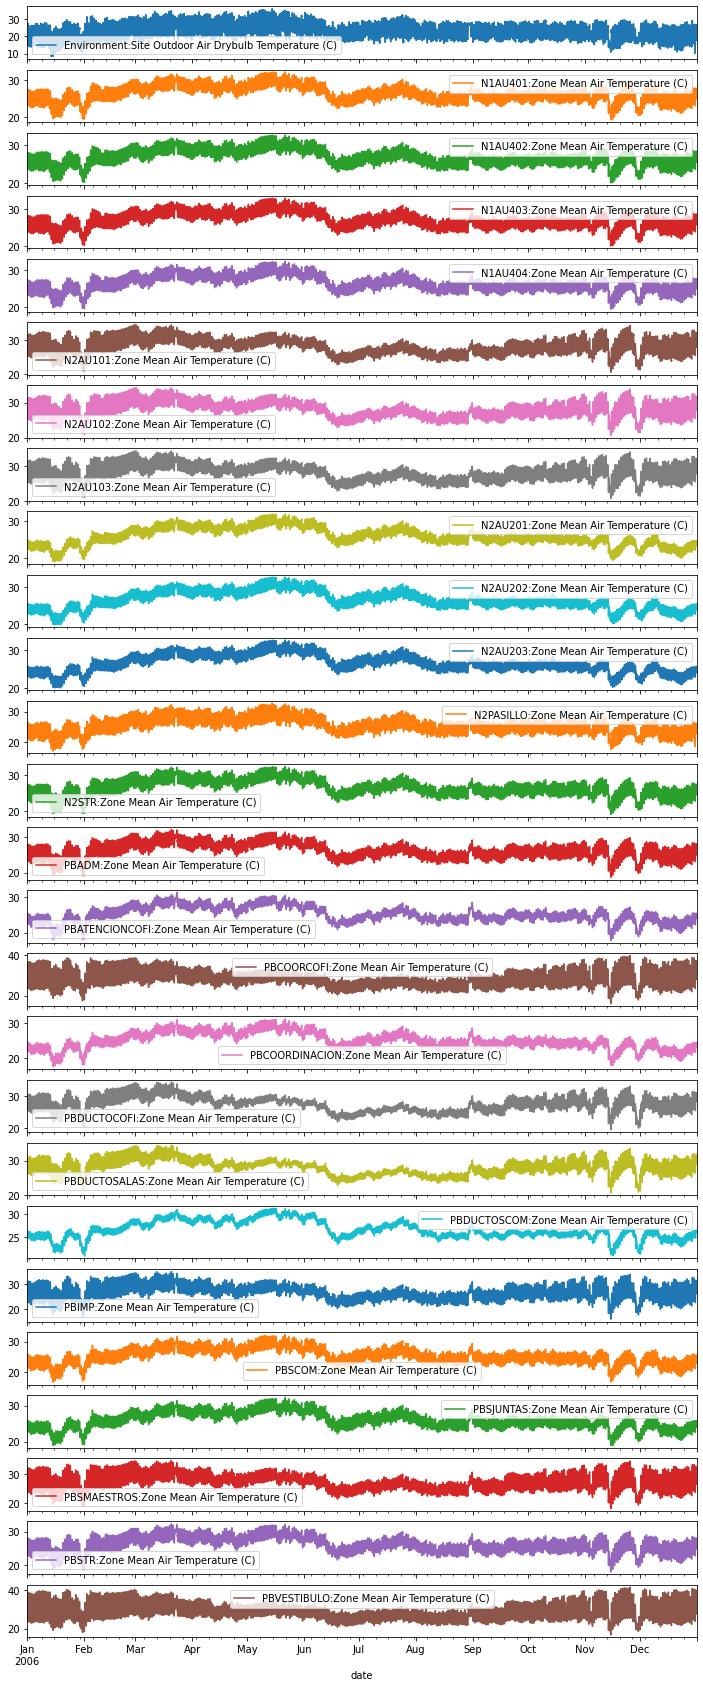

In [12]:
variables = ['Site Outdoor','Mean Air']
caso1 = df.get_data(variables)
caso1.plot(subplots=True,figsize=(12,30));

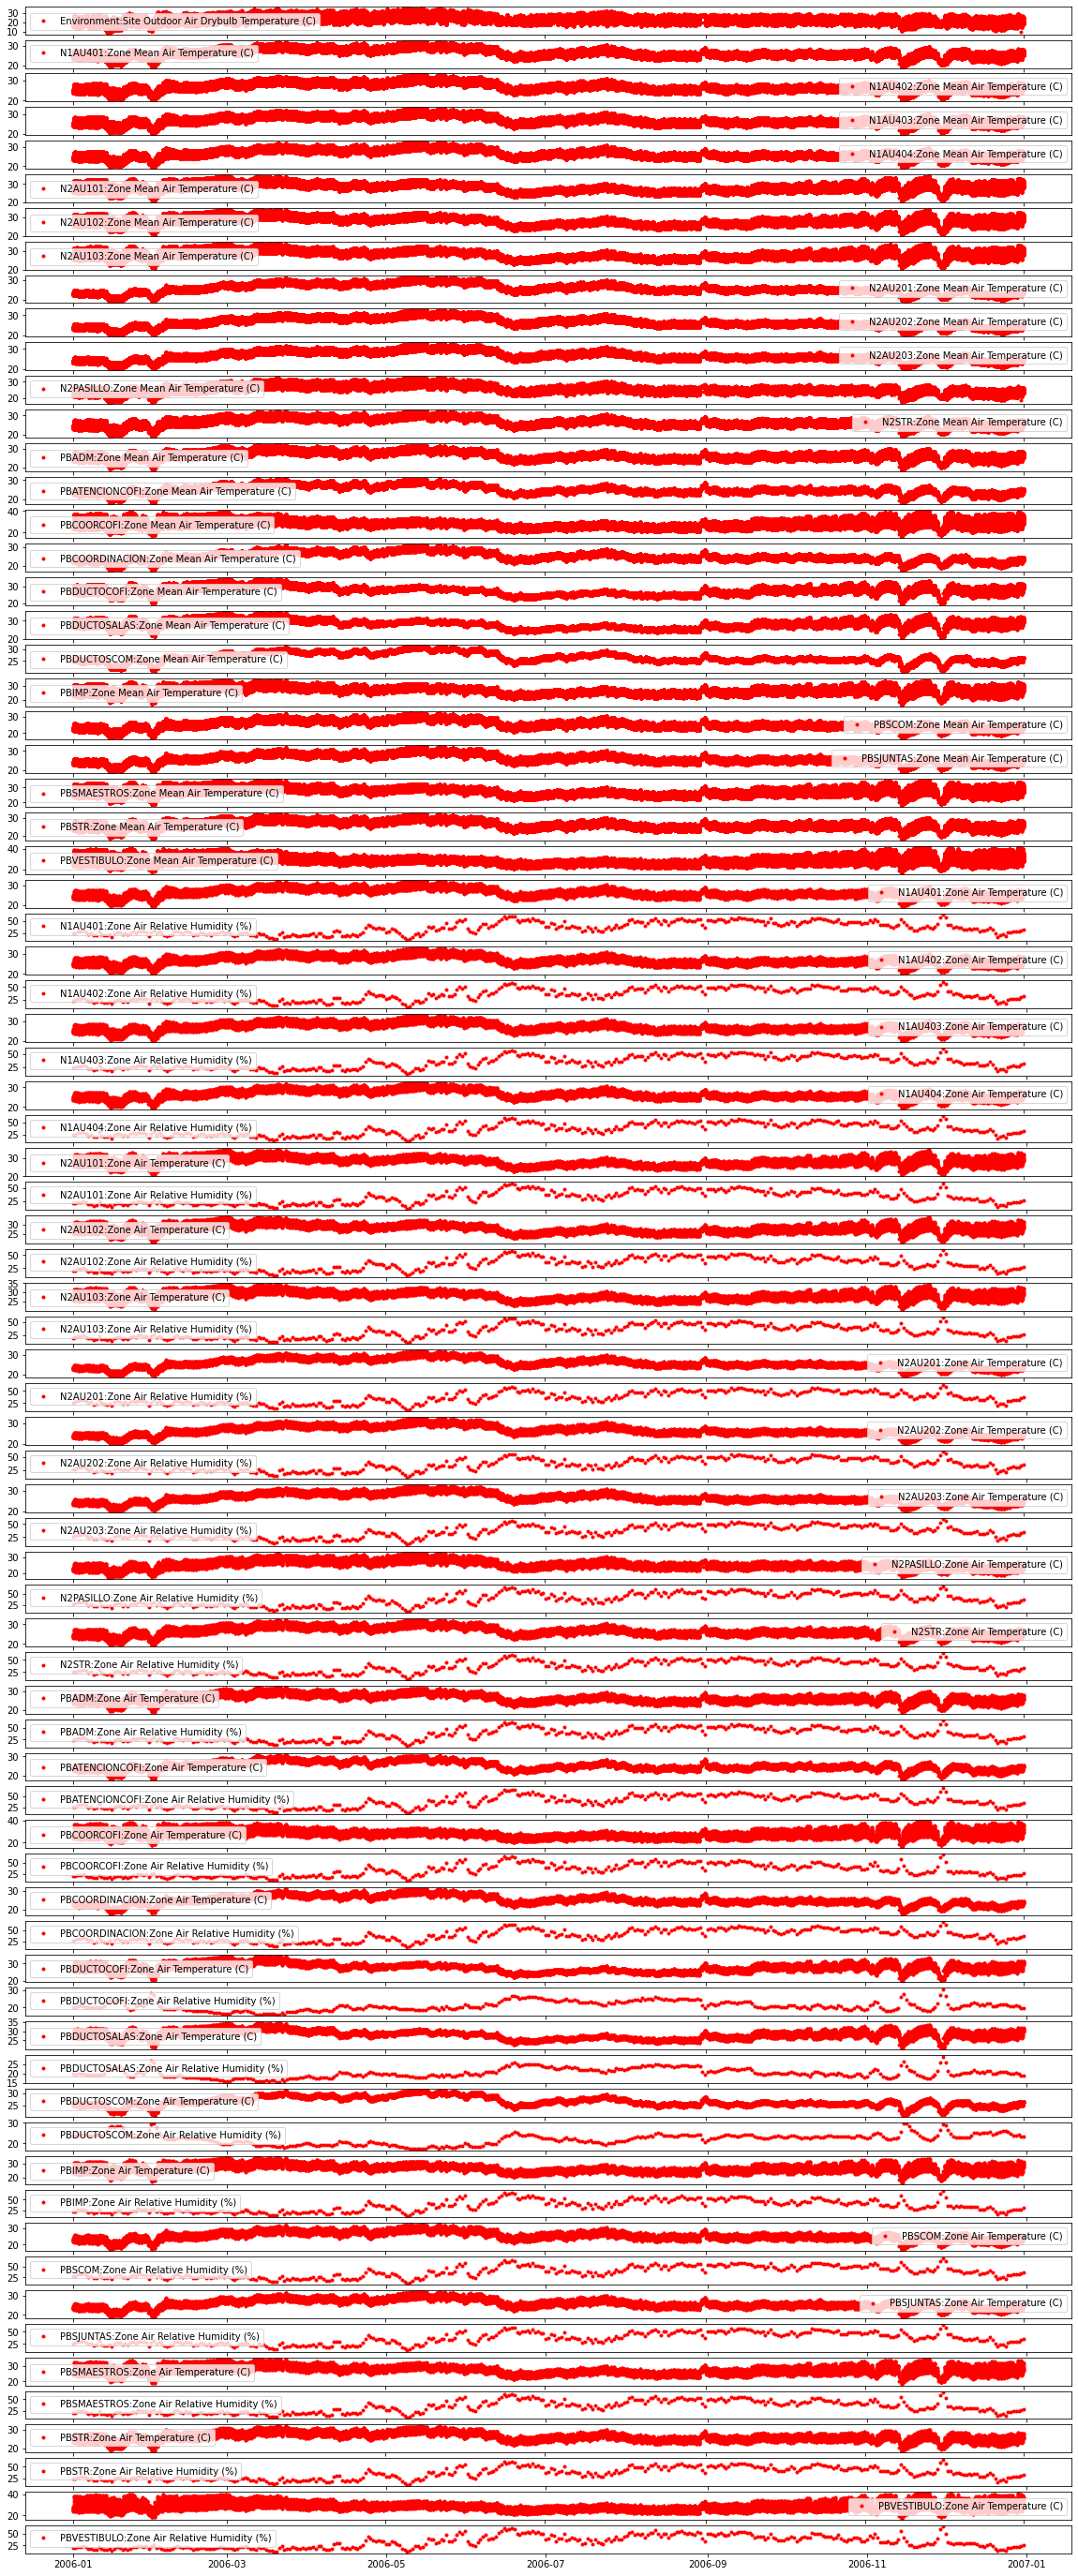

In [13]:
variables = df.vars
caso1 = df.get_data(variables)

fig, ax = plt.subplots(len(variables),figsize=(20,50))

for i,variable in enumerate(variables):
    ax[i].plot(caso1[variable].index,caso1[variable],'r.',label=variable)
    ax[i].legend()